In [1]:
'''
@File    :   thend.ipynb
@Time    :   2023/07/23 14:57:22
@Author  :   Ravi K.
@Desc    :   A notebook for testing combination of everything we have done.
'''

'\n@File    :   thend.ipynb\n@Time    :   2023/07/23 14:57:22\n@Author  :   Ravi K.\n@Desc    :   A notebook for testing combination of everything we have done.\n'

In [2]:
import final_script as fs
import numpy as np
import processing_functions as pf
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import skewnorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.backends.backend_pdf
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'figure.dpi':150,    
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [3]:
# snr, outliers, grb_mask, grb_snr = fs.find_grb("/home/ravioli/astro/ksp/grb/GRB190928A/1s", 307372337.0, 2)[0]

In [4]:
# t, *_ = fs.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/20-60/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc", 1702)
# grb = np.zeros_like(t['RATE'])
# plt.figure(figsize=(10,7))
# plt.subplot(2,1,1)
# grb[outliers] = snr[0]
# plt.plot(t['TIME'], grb, alpha=0.6, color='red', label='20-60keV')
# grb[outliers] = snr[1]
# plt.plot(t['TIME'], grb, alpha=0.6, color='blue', label='60-100keV')
# grb[outliers] = snr[2]
# plt.plot(t['TIME'], grb, alpha=0.6, color='green', label='100-200keV')
# plt.title("GRB190928A")
# plt.xlabel("Outliers")
# plt.ylabel("SNR")
# plt.legend()
# plt.subplot(2,1,2)
# grb[outliers] = 0
# grb[outliers[grb_mask]] = grb_snr
# plt.plot(t['TIME'], grb, alpha=0.6, color='slateblue', label='20-200keV')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [5]:
# snr, outliers, grb_mask, grb_snr = fs.find_grb("/home/ravioli/astro/ksp/grb/GRB210709A/1s", 363502145.0, 2.5)[1]

In [6]:
# detrended, raw, trend, *_ = fs.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB210709A/1s/3_bins/20-60/AS1A10_073T02_9000004522_31247cztM0_level2_quad_clean_Q1.lc", 3513)
# grb = np.zeros_like(detrended['RATE'])
# plt.figure(figsize=(10,7), dpi=150)
# plt.subplot(2,1,1)
# grb[outliers] = snr[0]
# plt.plot(detrended['TIME'], grb, alpha=0.6, color='red', label='20-60keV')
# grb[outliers] = snr[1]
# plt.plot(detrended['TIME'], grb, alpha=0.6, color='blue', label='60-100keV')
# grb[outliers] = snr[2]
# plt.plot(detrended['TIME'], grb, alpha=0.6, color='green', label='100-200keV')
# plt.title("GRB210709A")
# plt.xlabel("Outliers")
# plt.ylabel("SNR")
# plt.legend()
# plt.subplot(2,1,2)
# grb[outliers] = 0
# grb[outliers[grb_mask]] = grb_snr
# plt.plot(detrended['TIME'], grb, alpha=0.6, color='slateblue', label='20-200keV')
# plt.legend()
# plt.tight_layout()
# plt.show()

Master light curve already exists at /home/ravioli/astro/ksp/grb/GRB170330A/master_lc
Requested energy bins already exist at /home/ravioli/astro/ksp/grb/GRB170330A/3_bins


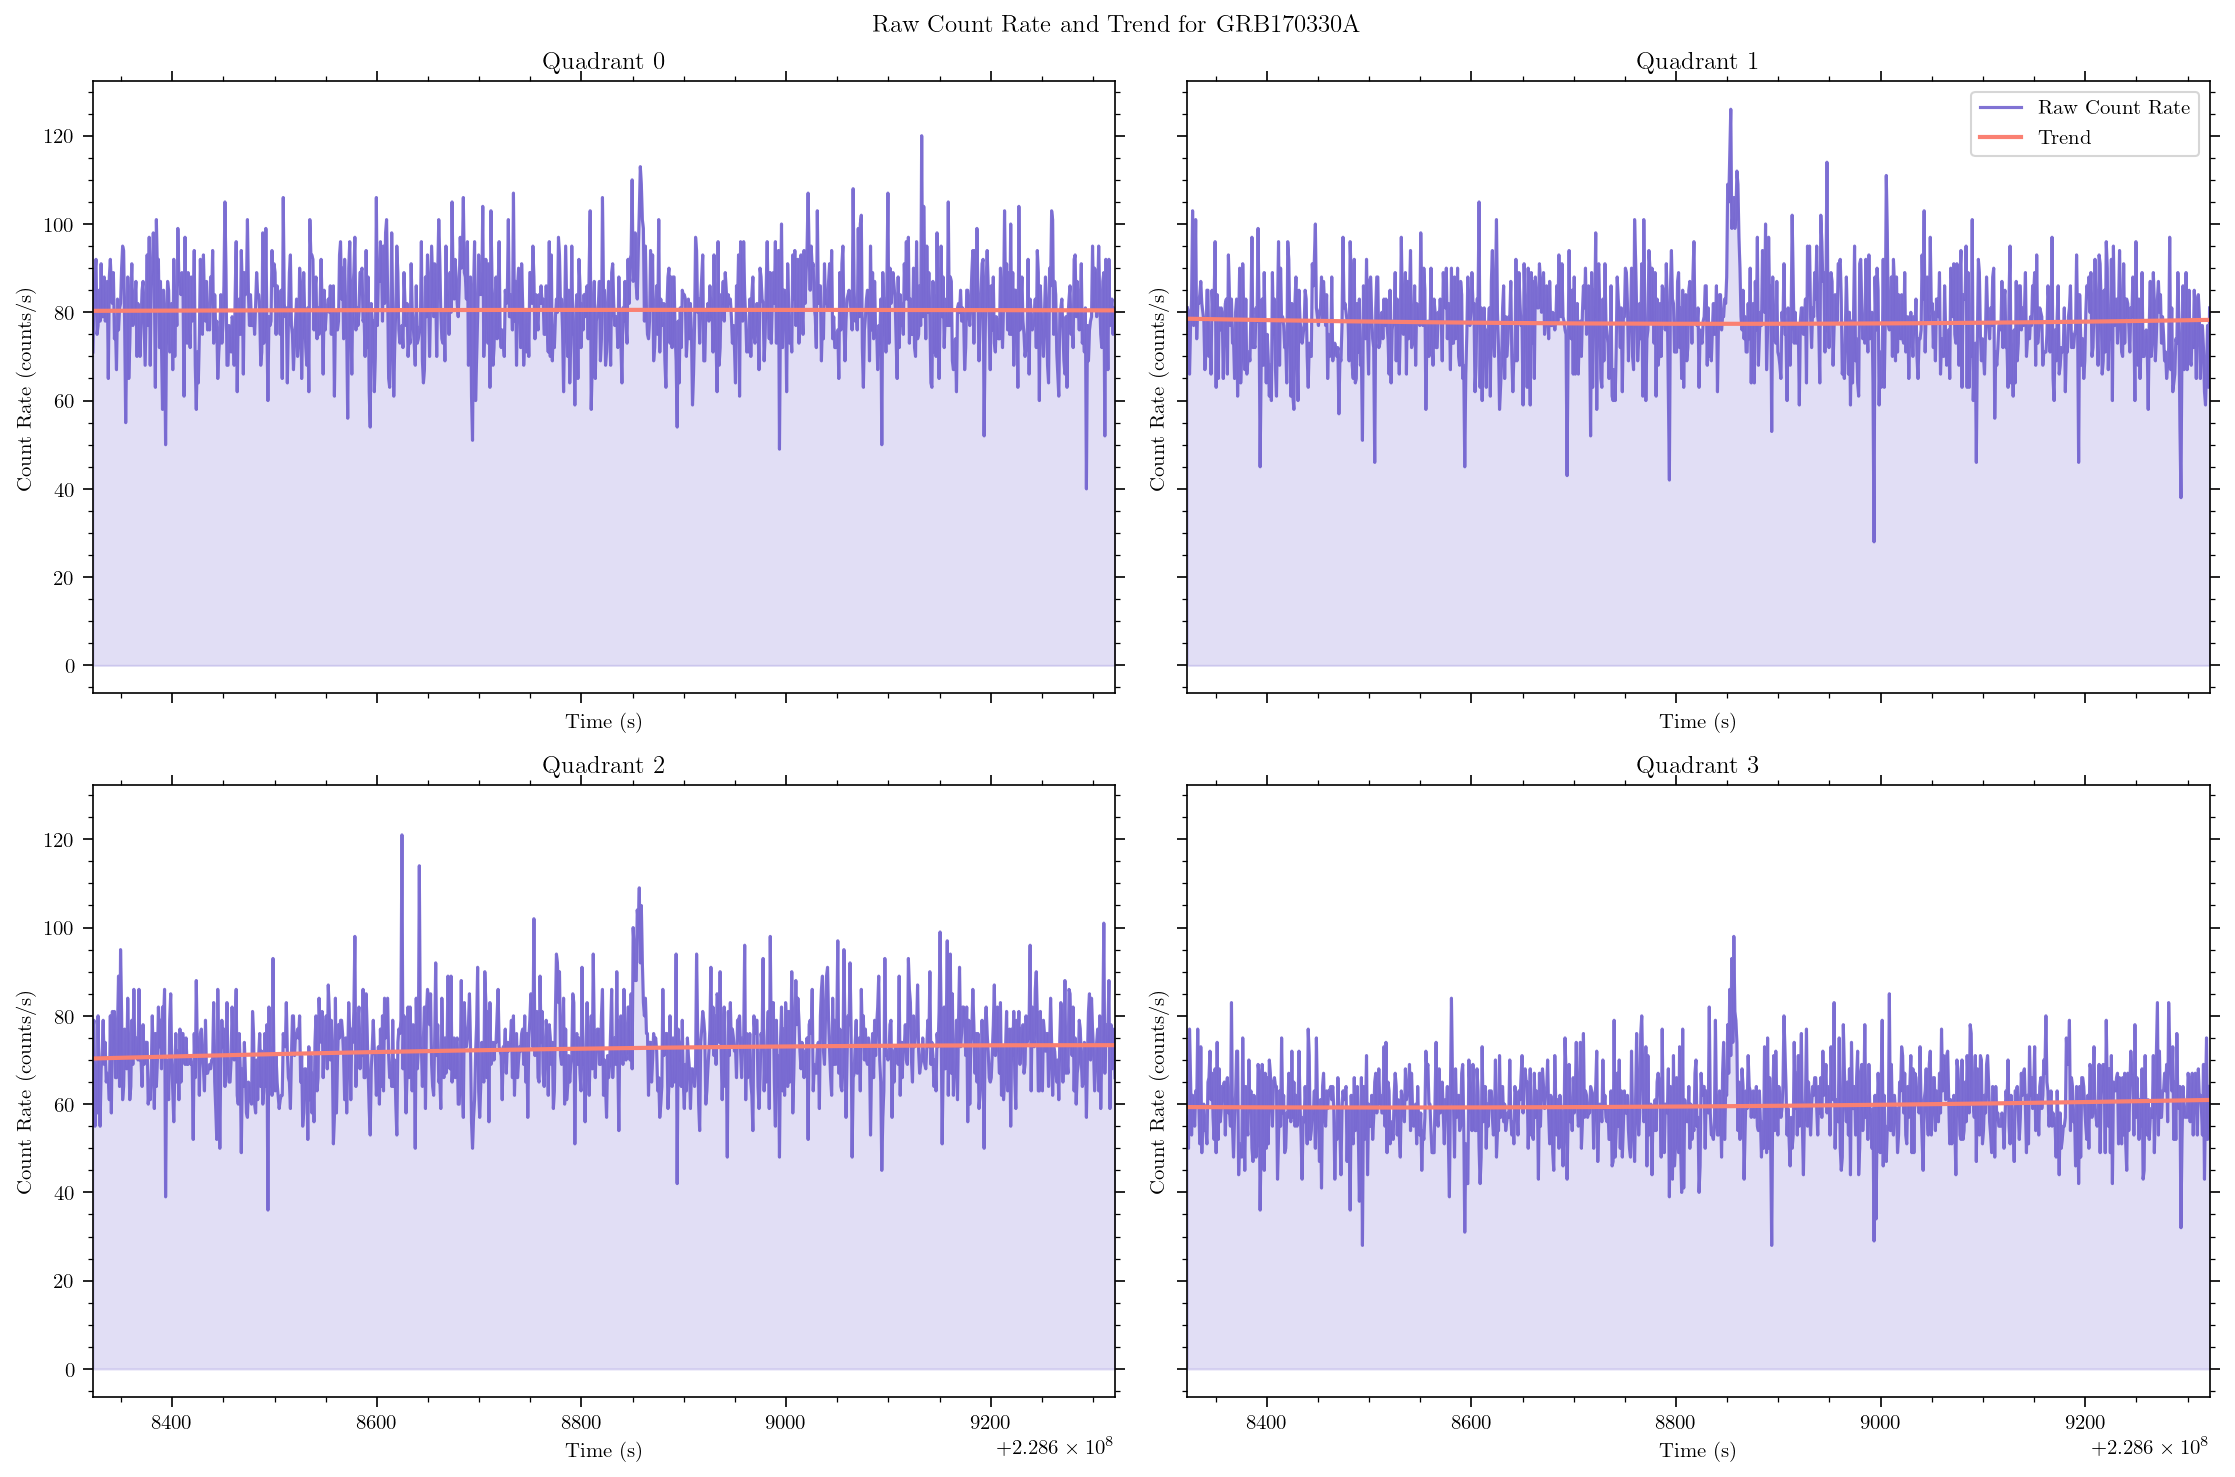

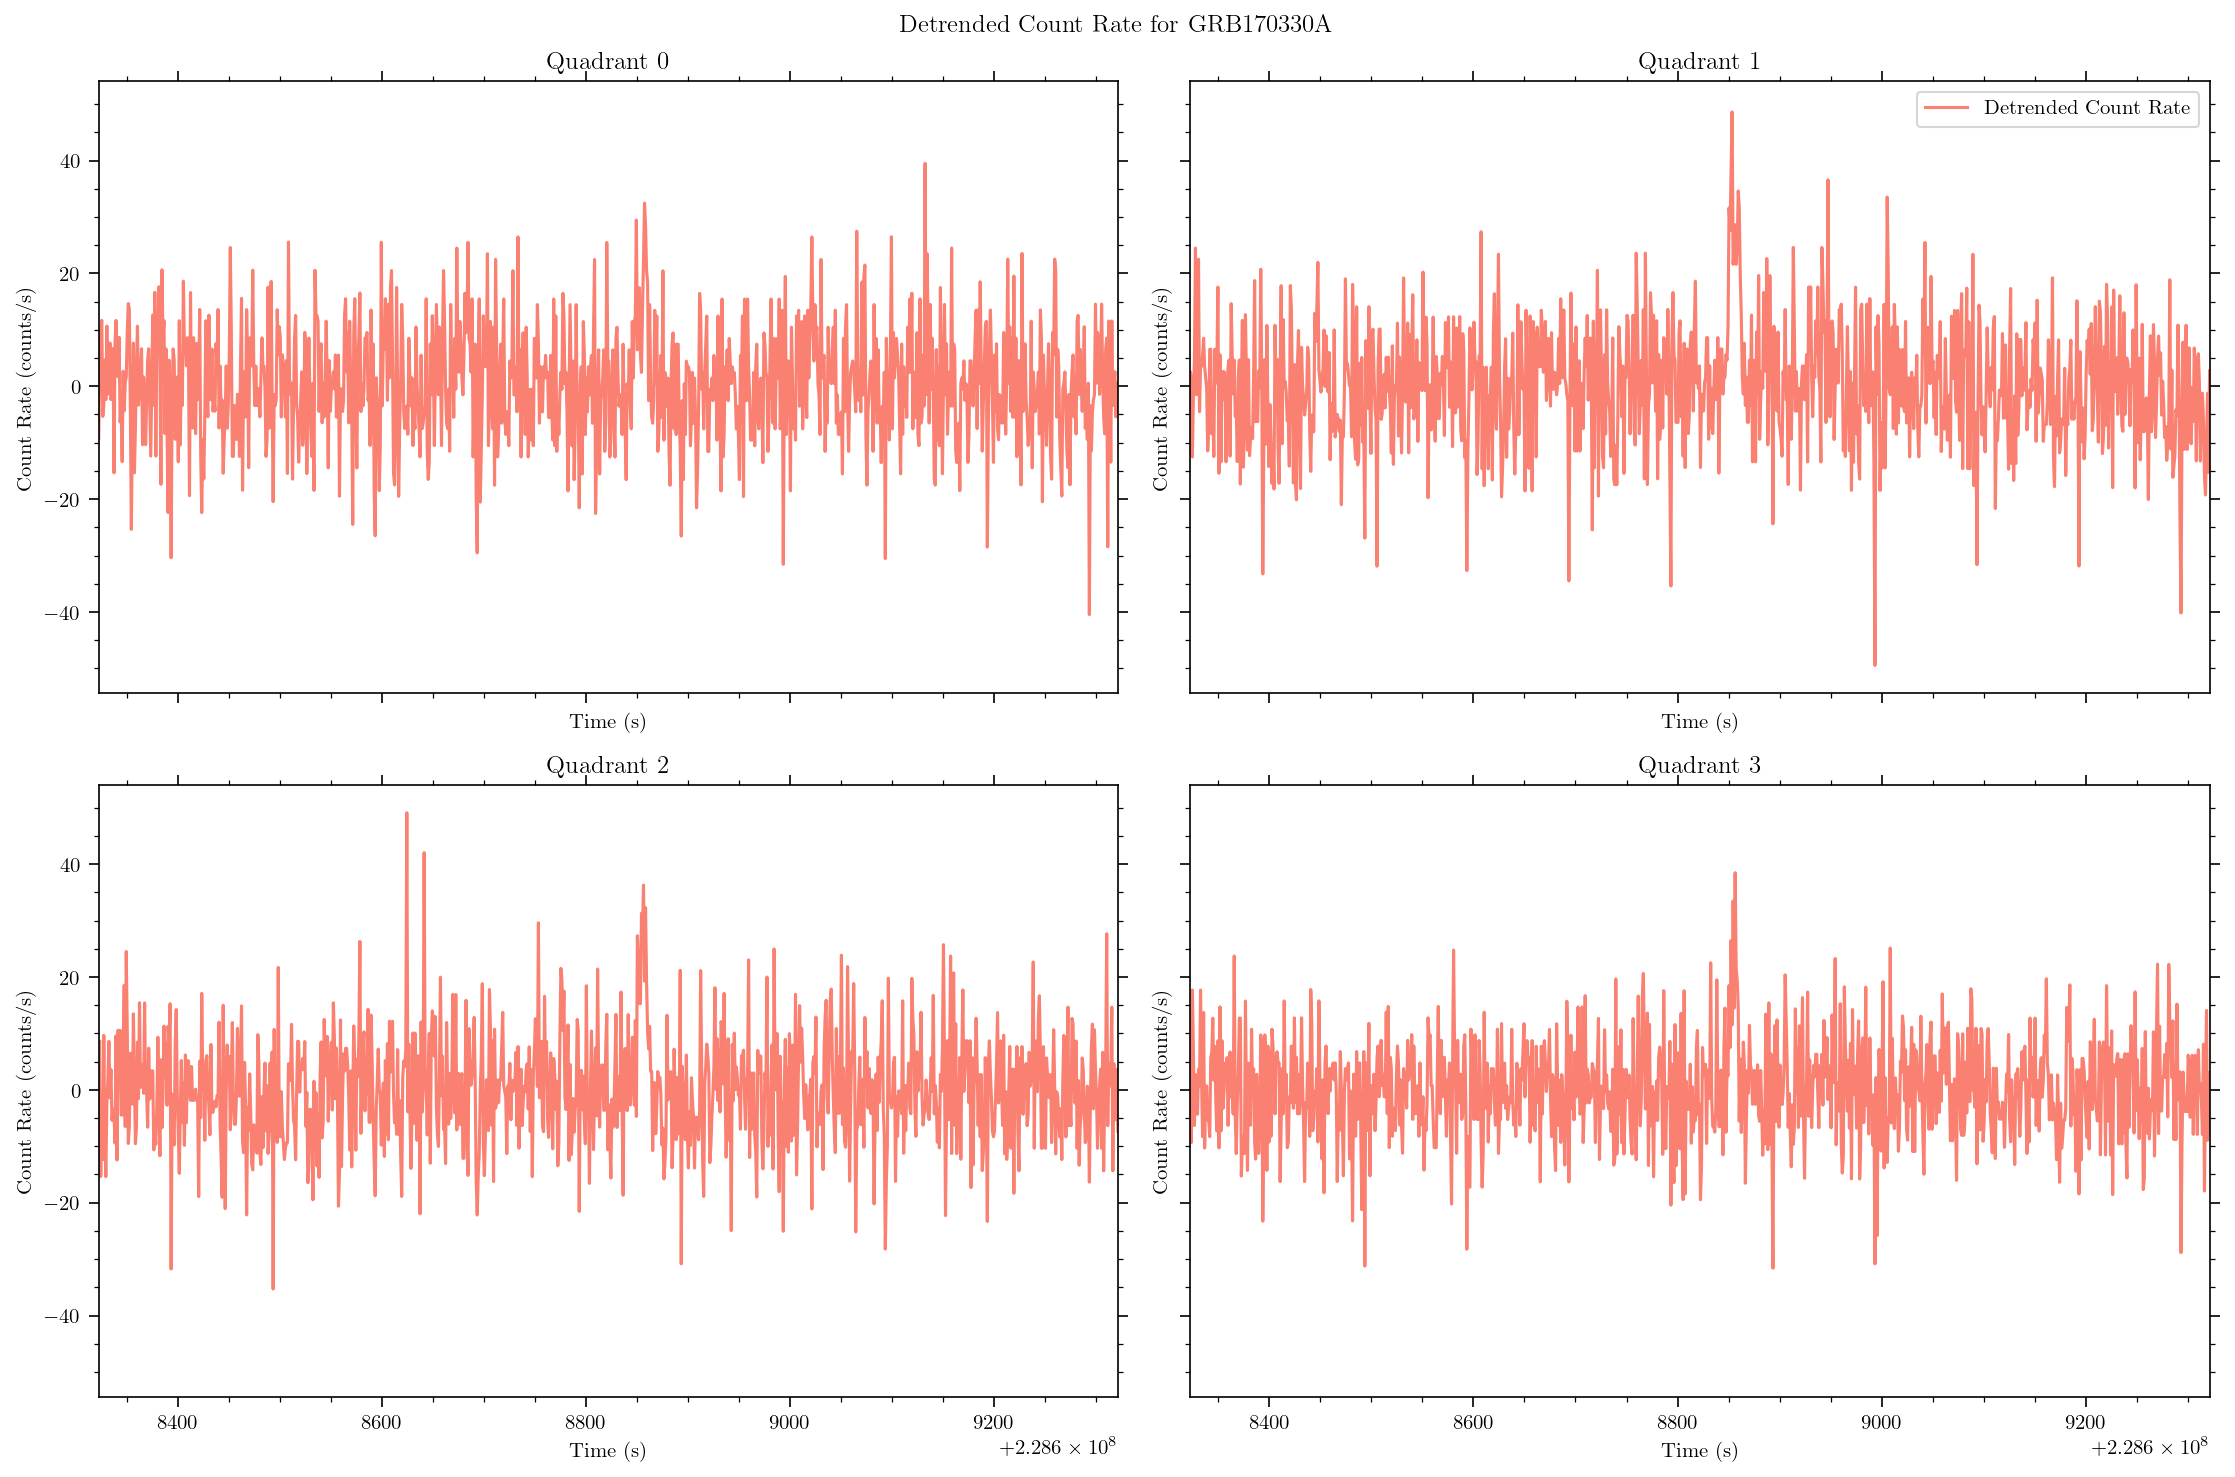

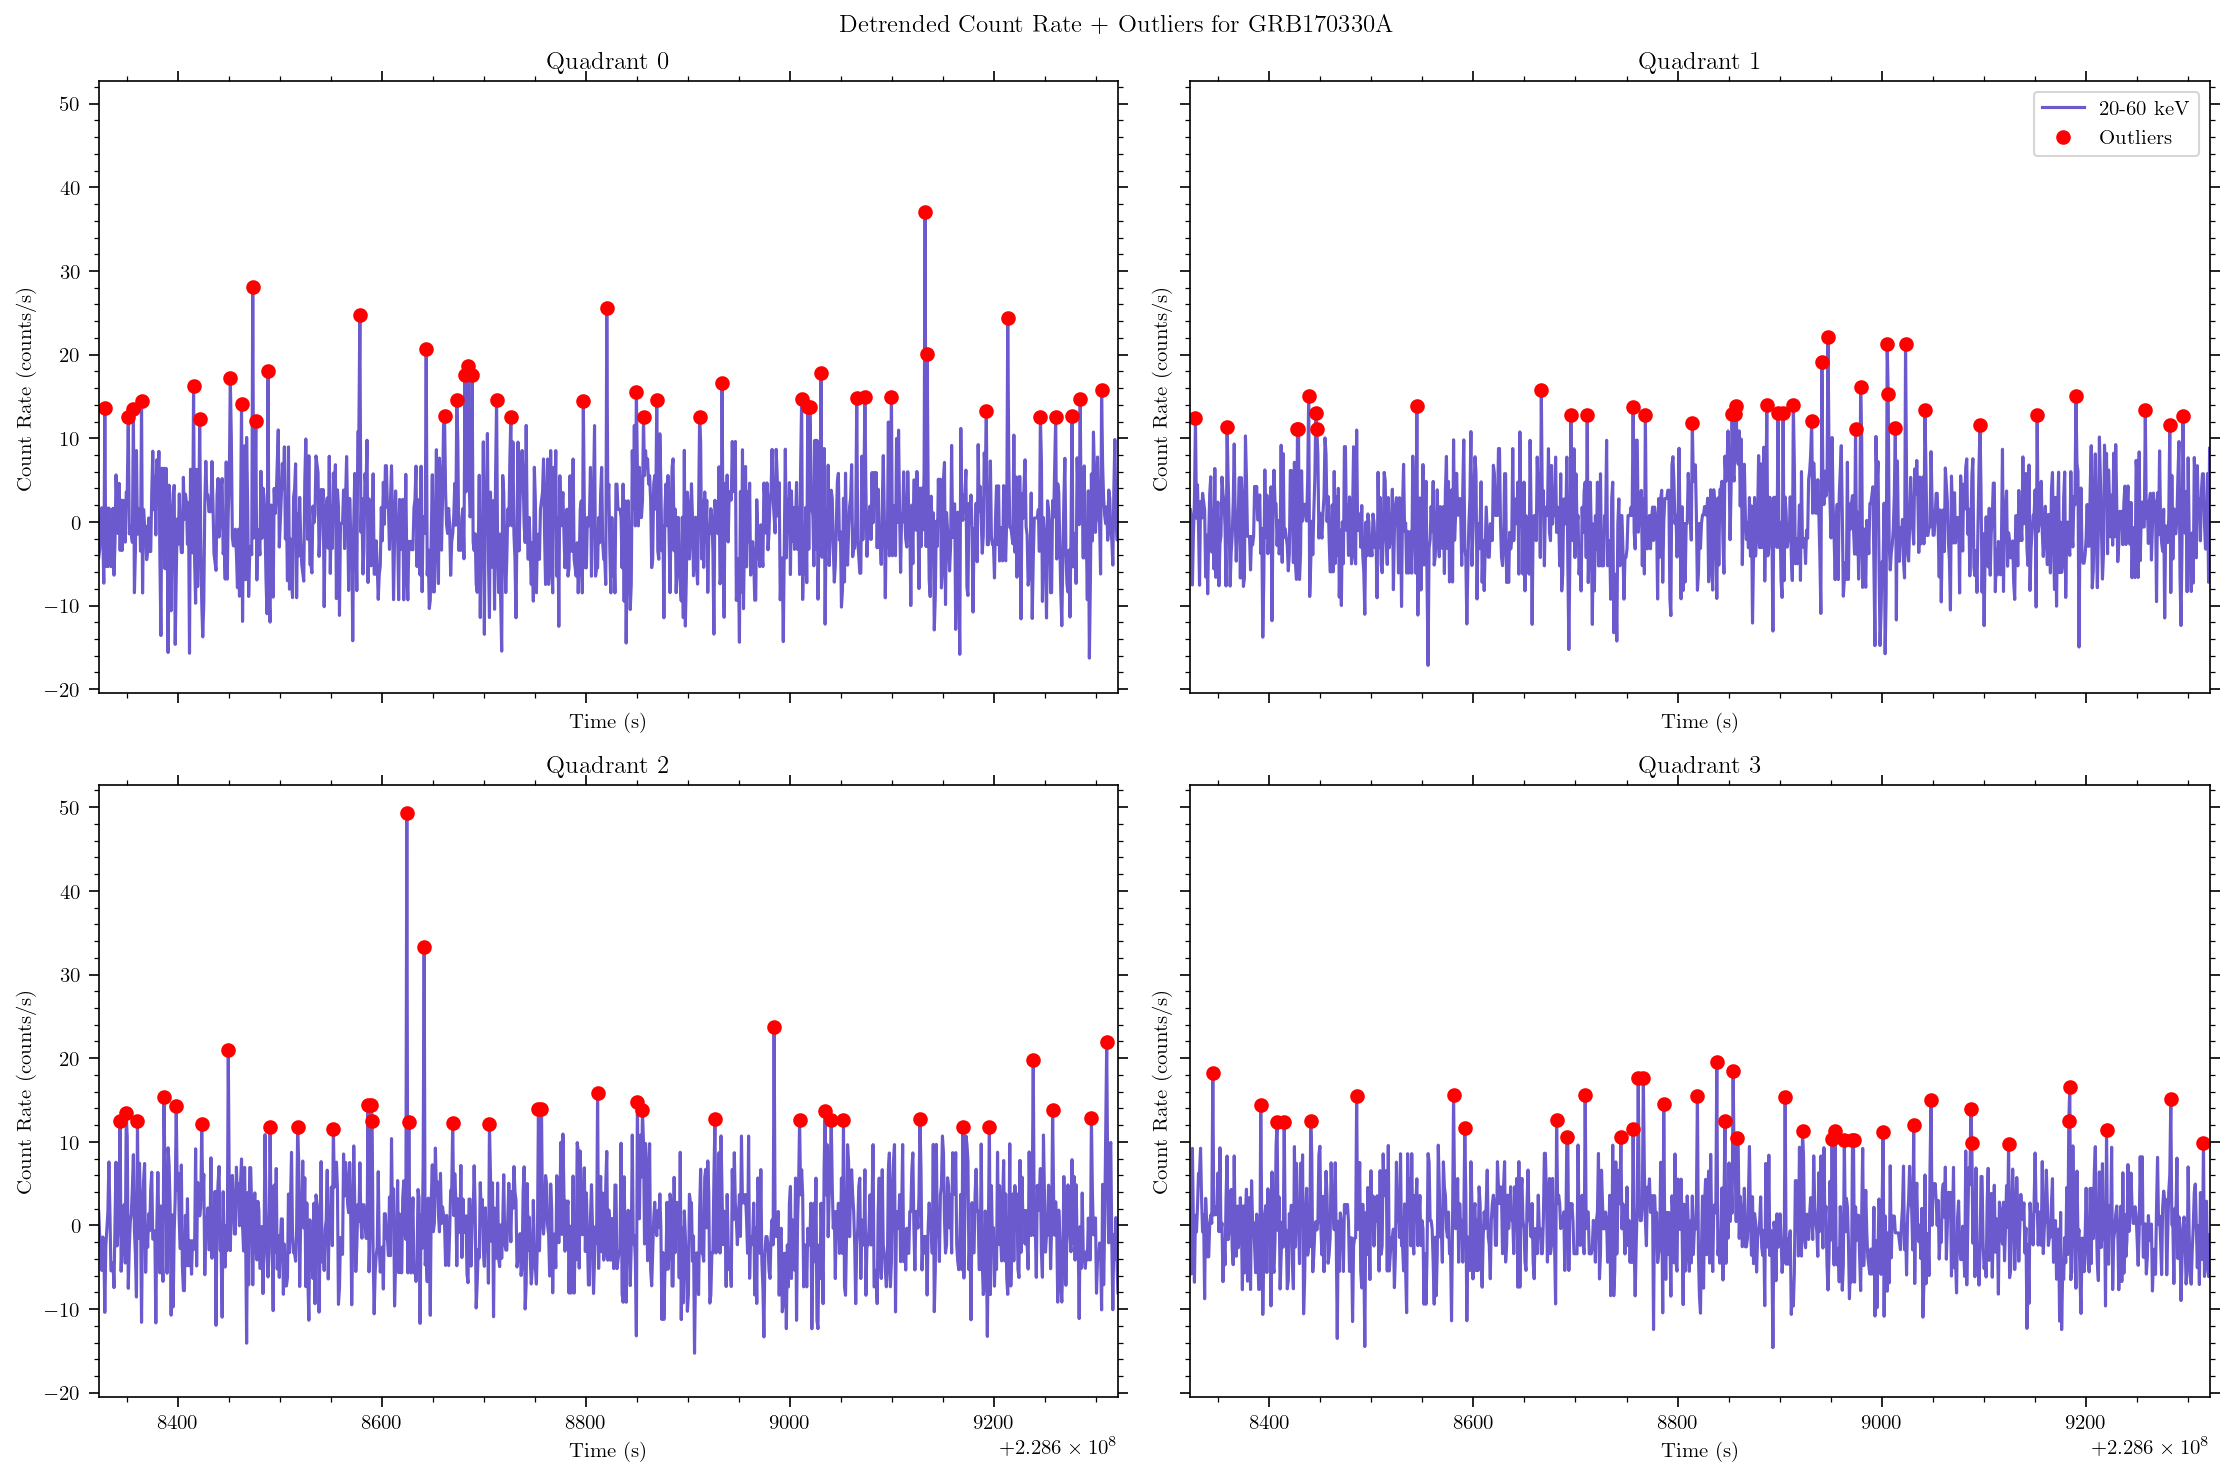

In [9]:
grb_name = "GRB170330A"
trigger_time = 228608821.0
results = fs.find_grb("/home/ravioli/astro/ksp/grb/GRB170330A", trigger_time, 2)
master_lcs = results[4]
lc_paths = np.sort(glob.glob(f"{results[5][0]}/*.lc"))

fig_raw, ax_raw = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
fig_raw.set_tight_layout(True)
fig_detrended, ax_detrended = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
fig_detrended.set_tight_layout(True)
fig_mark_outlier, ax_mark_outlier = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
fig_mark_outlier.set_tight_layout(True)
fig_snr_outlier, ax_snr_outlier = plt.subplots(4, 2, figsize=(15, 10), sharex=True, sharey=True)
fig_snr_outlier.set_tight_layout(True)

figs = [fig_raw, fig_detrended, fig_mark_outlier, fig_snr_outlier]

for i in range(4):
    trigger_index = fs.get_trigger_index(master_lcs[i], trigger_time)
    detrended, raw, trend, *_ = fs.quadratic_detrend_trigger(master_lcs[i], trigger_index, polyorder=2)
    detrended20to60, *_ = fs.quadratic_detrend_trigger(lc_paths[i], trigger_index, polyorder=2)
    ax_raw[i//2, i%2].plot(raw['TIME'], raw['RATE'], color='slateblue', label='Raw Count Rate', alpha=0.85)
    ax_raw[i//2, i%2].plot(raw['TIME'], trend, color='salmon', label='Trend', linewidth=2)
    ax_raw[i//2, i%2].fill_between(raw['TIME'], 0, raw['RATE'], color='slateblue', alpha=0.2)
    ax_raw[i//2, i%2].set_xlim(raw['TIME'][0], raw['TIME'][-1])
    ax_raw[i//2, i%2].set_xlabel("Time (s)")
    ax_raw[i//2, i%2].set_ylabel("Count Rate (counts/s)")
    ax_raw[i//2, i%2].set_title("Quadrant {}".format(i))
    if i == 1:
        ax_raw[i//2, i%2].legend()
    
    ax_detrended[i//2, i%2].plot(detrended['TIME'], detrended['RATE'], color='salmon', label='Detrended Count Rate')
    ax_detrended[i//2, i%2].set_xlim(detrended['TIME'][0], detrended['TIME'][-1])
    ax_detrended[i//2, i%2].set_xlabel("Time (s)")
    ax_detrended[i//2, i%2].set_ylabel("Count Rate (counts/s)")
    ax_detrended[i//2, i%2].set_title("Quadrant {}".format(i))
    if i == 1:
        ax_detrended[i//2, i%2].legend()
    
    snr, outliers, grb_mask, grb_snr = results[i]
    ax_mark_outlier[i//2, i%2].plot(detrended20to60['TIME'], detrended20to60['RATE'], color='slateblue', label='20-60 keV')
    ax_mark_outlier[i//2, i%2].plot(detrended20to60['TIME'][outliers], detrended20to60['RATE'][outliers], 'o', color='red', label='Outliers')
    ax_mark_outlier[i//2, i%2].set_xlim(detrended20to60['TIME'][0], detrended20to60['TIME'][-1])
    ax_mark_outlier[i//2, i%2].set_xlabel("Time (s)")
    ax_mark_outlier[i//2, i%2].set_ylabel("Count Rate (counts/s)")
    ax_mark_outlier[i//2, i%2].set_title("Quadrant {}".format(i))
    if i == 1:
        ax_mark_outlier[i//2, i%2].legend()
    
    grb = np.zeros_like(detrended['RATE'])
    grb[outliers] = snr[0]
    ax_snr_outlier[i, 0].plot(detrended['TIME'], grb, alpha=0.6, color='red', label='20-60keV')
    grb[outliers] = snr[1]
    ax_snr_outlier[i, 0].plot(detrended['TIME'], grb, alpha=0.6, color='blue', label='60-100keV')
    grb[outliers] = snr[2]
    ax_snr_outlier[i, 0].plot(detrended['TIME'], grb, alpha=0.6, color='green', label='100-200keV')
    ax_snr_outlier[i, 0].set_xlim(detrended['TIME'][0], detrended['TIME'][-1])
    ax_snr_outlier[i, 0].set_title("Quadrant {} Outliers".format(i))
    ax_snr_outlier[i, 0].set_xlabel("Outliers")
    ax_snr_outlier[i, 0].set_ylabel("SNR")
    grb[outliers] = 0
    grb[outliers[grb_mask]] = grb_snr
    ax_snr_outlier[i, 1].plot(detrended['TIME'], grb, alpha=0.6, color='slateblue', label='20-200keV')
    ax_snr_outlier[i, 1].set_xlim(detrended['TIME'][0], detrended['TIME'][-1])
    ax_snr_outlier[i, 1].set_title("Quadrant {} Possible GRBs".format(i))
    ax_snr_outlier[i, 1].set_xlabel("Outliers")
    ax_snr_outlier[i, 1].set_ylabel("SNR")
    if i == 0:
        ax_snr_outlier[i, 0].legend()
        ax_snr_outlier[i, 1].legend()

fig_detrended.suptitle(f"Detrended Count Rate for {grb_name}")
fig_raw.suptitle(f"Raw Count Rate and Trend for {grb_name}")
fig_mark_outlier.suptitle(f"Detrended Count Rate + Outliers for {grb_name}")
fig_snr_outlier.suptitle(f"SNR vs Outliers for {grb_name}")
pdf = matplotlib.backends.backend_pdf.PdfPages(f"output_for_{grb_name}.pdf")
for fig in figs:
    pdf.savefig(fig)
pdf.close()
plt.close()